# Analyzing Carbon Dioxide Removal (CDR) Metrics

This notebook performs a Carbon Dioxide Removal (CDR) analysis using C-Star model output and grid data. We 

* compute CDR efficiency curves
* visualize the results
* and save a dedicated CDR dataset to NetCDF for further analysis or verification.

In [1]:
from roms_tools import Grid, ROMSOutput

First, we read the grid data from a file. For more details, see [this page](https://roms-tools.readthedocs.io/en/latest/grid.html#Creating-a-grid-from-an-existing-NetCDF-or-YAML-file) on creating a grid from an existing NetCDF (or YAML) file.

In [2]:
grid = Grid.from_file("/global/cfs/projectdirs/m4746/Datasets/ROMSOutput/northatl15km/natl15km_grd.nc")

Next, we read the C-Star model output. For more details, see [this page](https://roms-tools.readthedocs.io/en/latest/reading_roms_output.html) on reading ROMS output data.

In [3]:
roms_output = ROMSOutput(
    grid=grid,
    path=[
        "/global/cfs/projectdirs/m4746/Datasets/ROMSOutput/northatl15km/natl15km_cstar.nc"
    ],
    use_dask=True,
)

In [4]:
roms_output.ds

<xarray.Dataset> Size: 10GB
Dimensions:         (time: 91, eta_rho: 130, xi_rho: 130, s_rho: 50)
Coordinates:
    abs_time        (time) datetime64[ns] 728B 2000-01-16 ... 2000-04-15
    lat_rho         (eta_rho, xi_rho) float64 135kB ...
    lon_rho         (eta_rho, xi_rho) float64 135kB ...
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables: (12/22)
    ocean_time      (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
    zeta            (time, eta_rho, xi_rho) float64 12MB dask.array<chunksize=(1, 130, 130), meta=np.ndarray>
    temp            (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    salt            (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    ALK             (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    DIC             (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    ...              ...
    ALK_source      (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    ALK_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    DIC_source      (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    DIC_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    avg_begin_time  (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
    avg_end_time    (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    global_x:           128
    global_y:           128
    title:              mid North Atlantic domain
    grid_file:          ./input_files/partitioned_files/grid_1000x1000x50.00.nc
    forcing_files:       ./input_files/partitioned_files/surf_phys_filepath_2...
    forcing_info:       
    ...                 ...
    pipe_frc_options:   OFF
    particle_options:   OFF
    git_version:        04a38bebe846426838b40ba556b86fdda46d33ea
    averaging:          All variables are averaged in time
    history:            Mon Aug 18 18:23:06 2025: ncrcat ../mid_NAtl_big_csta...
    NCO:                netCDF Operators version 5.3.4 (Homepage = http://nco...

In this experiment, an alkalinity source has been added to the middle of the Atlantic domain. This can be visualized by plotting the uppermost layer of `ALK_source`, a variable from the C-Star output. For more details on visualizing ROMS output fields, see [this page](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html).

[########################################] | 100% Completed | 100.94 ms


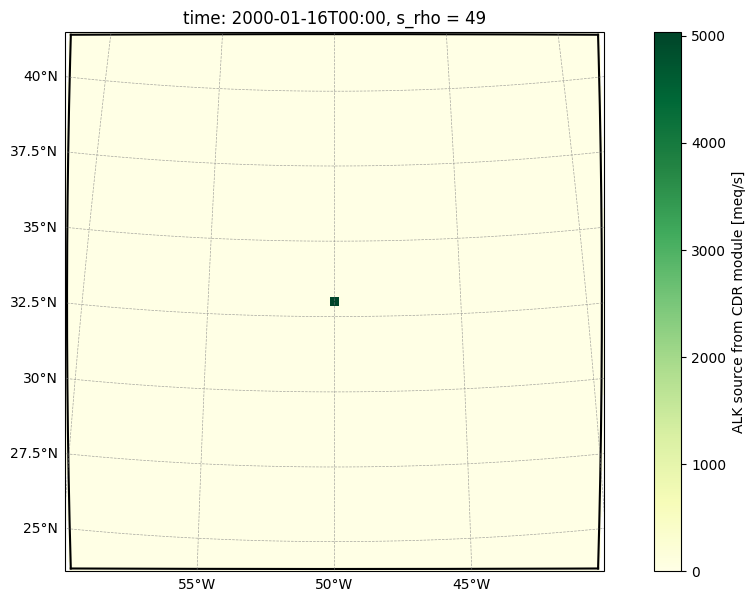

In [5]:
roms_output.plot("ALK_source", s=-1)

## CDR uptake efficiency

A key metric in CDR analysis is the **CDR uptake efficiency**, which can be computed in two ways (see also [here](https://registry.isometric.com/module/air-sea-gas-exchange/1.0#analysis-of-model-output)):
1. Using CO2 flux differences:
\begin{equation}
\eta_\text{flux}(t_f) =
\frac{
\displaystyle \int_{t_0}^{t_f} \int \big( \Phi_\text{intervention} - \Phi_\text{baseline} \big) \, dA \,  dt
}{
\displaystyle \int_{t_0}^{t_f} \int \big(\text{ALK}_\text{source} + \text{DIC}_\text{sink} \big) \, dV \, dt
}
\end{equation}
3. Using DIC differences:
\begin{equation}
\eta_\text{DIC}(t_f) =
\frac{
\displaystyle \int_{t_0}^{t_f} \int \big( \text{DIC}_\text{intervention} - \text{DIC}_\text{baseline} \big) \, dV \,  dt
}{
\displaystyle \int_{t_0}^{t_f} \int \big(\text{ALK}_\text{source} + \text{DIC}_\text{sink} \big) \, dV \, dt
}
\end{equation}

| Symbol | Meaning | Units |
|--------|---------|-------|
| $t_0$, $t_f$ | Start and end times | s |
| $\Phi_\text{intervention}$ | CO₂ flux with intervention | mol/m²/s |
| $\Phi_\mathrm{baseline}$ | CO₂ flux without intervention | mol/m²/s |
| $\text{DIC}_\text{intervention}$ | DIC with intervention | mol/m³ |
| $\text{DIC}_\text{baseline}$ | DIC without intervention | mol/m³ |
| $\text{ALK}_\text{source}$ | Added alkalinity (intervention)| mol |
| $\text{DIC}_\text{sink}$ | Removed DIC (intervention)| mol |
| $dA$ | Grid cell area | m² |
| $dV$ | Grid cell volume | m³ |

We can perform a CDR analysis, including computing the CDR uptake efficiency in both ways, by calling the method `.cdr_metrics()`. This method will automatically compute the required diagnostics (if not already present), save them in the attribute `.ds_cdr`, and produce a plot of the uptake efficiency over time.

INFO - Max absolute difference between flux-based and DIC-based uptake efficiency: 2.900e-04


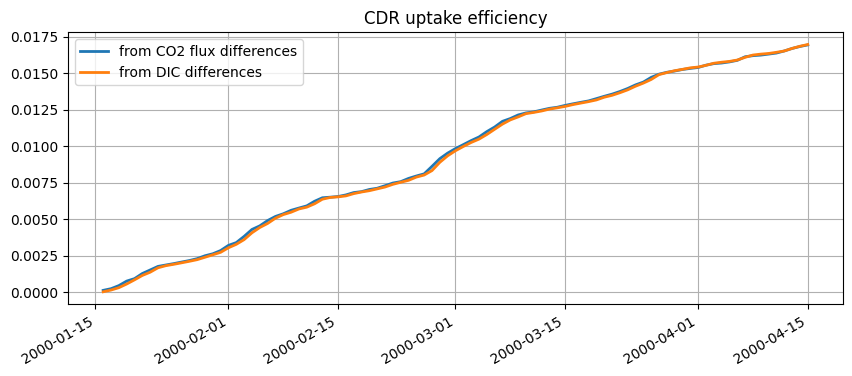

In [6]:
roms_output.cdr_metrics()

## CDR-relevant metrics

After running `.cdr_metrics()`, a new attribute `ds_cdr` is created, containing all CDR-relevant outputs.

In [7]:
roms_output.ds_cdr

<xarray.Dataset> Size: 1GB
Dimensions:                         (time: 91, eta_rho: 130, xi_rho: 130,
                                     s_rho: 50)
Coordinates:
    abs_time                        (time) datetime64[ns] 728B 2000-01-16 ......
    lat_rho                         (eta_rho, xi_rho) float64 135kB 23.52 ......
    lon_rho                         (eta_rho, xi_rho) float64 135kB 300.2 ......
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables:
    FG_CO2                          (time, eta_rho, xi_rho) float64 12MB dask.array<chunksize=(1, 130, 130), meta=np.ndarray>
    FG_ALT_CO2                      (time, eta_rho, xi_rho) float64 12MB dask.array<chunksize=(1, 130, 130), meta=np.ndarray>
    hDIC                            (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    hDIC_ALT_CO2                    (time, s_rho, eta_rho, xi_rho) float64 615MB dask.array<chunksize=(1, 50, 130, 130), meta=np.ndarray>
    area                            (eta_rho, xi_rho) float64 135kB 2.392e+08...
    window_length                   (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
    cdr_efficiency                  (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
    cdr_efficiency_from_delta_diff  (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>

We can save the CDR-relevant outputs (stored in `.ds_cdr`) to a NetCDF file using xarray's `.to_netcdf()` method.

In [8]:
roms_output.ds_cdr.to_netcdf("/pscratch/sd/n/nloose/output/cdr_metrics.nc")

## Ensembles of CDR efficiency curves

In [13]:
roms_output_with_march_release = ROMSOutput(
    grid=grid,
    path=[
        "/pscratch/sd/s/smaticka/roms_marbl/sims_runtime/mid_NAtl_big/output_noFe_diffTime/joined_files/mid_NAtl_big_cstar.nc"
    ],
    use_dask=True,
)

2025-09-25 13:31:59 - INFO - Max absolute difference between flux-based and DIC-based uptake efficiency: 2.970e-04


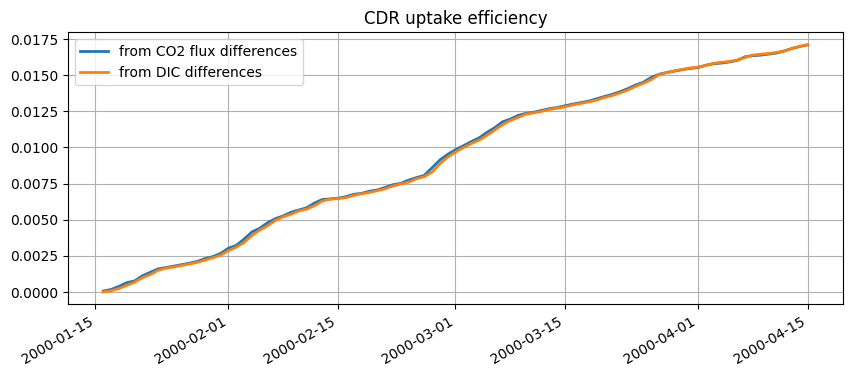

In [14]:
roms_output_with_march_release.cdr_metrics()

In [15]:
roms_output_with_march_release.ds_cdr.to_netcdf("/pscratch/sd/n/nloose/output/cdr_metrics_from_march_release.nc")

In [18]:
from roms_tools.setup.cdr_ensemble import Ensemble

In [19]:
ensemble = Ensemble(members={"January": roms_output.ds_cdr, "March": roms_output_with_march_release.ds_cdr})

In [20]:
ensemble.ds

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 91)
Coordinates:
  * time     (time) timedelta64[s] 728B 0 days 1 days 2 days ... 89 days 90 days
Data variables:
    January  (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>
    March    (time) float64 728B dask.array<chunksize=(1,), meta=np.ndarray>

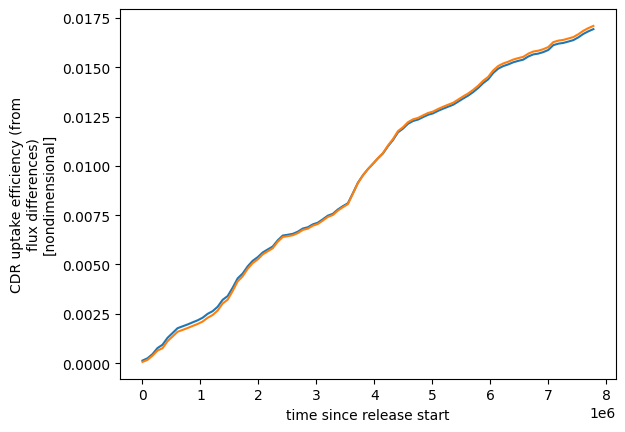

In [21]:
ensemble.ds["January"].plot()
ensemble.ds["March"].plot()